In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_imgs_path = data_dir /  'specificity_IF_best'  /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)


In [5]:
df_imgs

,Condition,FOV,Z,Path
0,Control,Control,0,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
1,Control,Control,1,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
2,Control,Control,2,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
3,Control,Control,3,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
4,KO,KO,0,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
5,KO,KO,1,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
6,KO,KO,2,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
7,KO,KO,3,Y:\coskun-lab\Thomas\23_PLA_revision\data\spec...


# Combine images

In [44]:
max_proj_dir = data_dir /  'specificity_IF_best' / 'imgs' / 'proj' 
max_proj_dir.mkdir(parents=True, exist_ok=True)

In [47]:
group = df_imgs.groupby('Condition')

for name, df_group in group:
    
    # Read image from all z
    imgs_all_z = []
    for row in df_group.itertuples():
        # Read image
        path = row.Path
        with h5py.File(path, "r") as f:
            imgs = f['imgs'][:]
            markers = f['imgs'].attrs['Marker']
        imgs_all_z.append(imgs)
    
    # Project maximum along z 
    imgs = np.max(imgs_all_z, axis=0)
    
    for i,m in enumerate(markers):
        save_path = max_proj_dir / f'{name}_{m}.tiff'
        tiff.imwrite(save_path, imgs[i])

# QC segmentation

In [38]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    # mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=small_size)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [42]:
# Read masks paths 
mask_dir = data_dir / 'specificity_IF_best' / 'imgs' / 'masks'
mask_filt_dir = data_dir / 'specificity_IF_best' / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [43]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = row.Condition
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    mask_nuclei = mask_nuclei[:mask_cyto.shape[0], :mask_cyto.shape[1]]
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

# Quantification mean expression

In [9]:
import skimage 

def read_intensity_per_cell(img, marker, mask):
    props = skimage.measure.regionprops_table(
        mask, img, properties=["label", "mean_intensity"]
    )
    df_prop = pd.DataFrame(props)
    df_prop["mean_intensity"] = df_prop["mean_intensity"]
    df_prop.columns = ["Cell_label", marker]
    return df_prop


In [10]:
mask_filt_dir = data_dir / 'specificity_IF_best' / 'imgs' / 'masks_filtered'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [11]:
max_proj_dir = data_dir /  'specificity_IF_best' / 'imgs' / 'proj' 
df_imgs_path = data_dir /  'specificity_IF_best'  /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)

group = df_imgs.groupby('Condition')

df_props = []
for name, df_group in group:
    bim_path = max_proj_dir / f'{name}_Bim.tiff'
    img = skimage.io.imread(bim_path)
    
    # Read masks
    mask_cell_path = masks_path[name]['cell']
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cell = skimage.io.imread(mask_cell_path)
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    for t,m in list(zip(['Cell', 'Cyto', 'Nuclei'], [mask_cell, mask_cyto, mask_nuclei])):
        df_prop = read_intensity_per_cell(img, 'Bim', m)
        df_prop['Conditon'] = name
        df_prop['Type'] = t
        df_props.append(df_prop)

In [12]:
df = pd.concat(df_props)

In [20]:
# Describe statistics
df.groupby(['Conditon', 'Type'])['Bim'].describe().to_excel('data.xlsx')

In [13]:
from statannotations.Annotator import Annotator

In [14]:
def plot(plotting, figsize=(7,7), y_title='Bim mean expression'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True, edgecolor='k', size=5)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

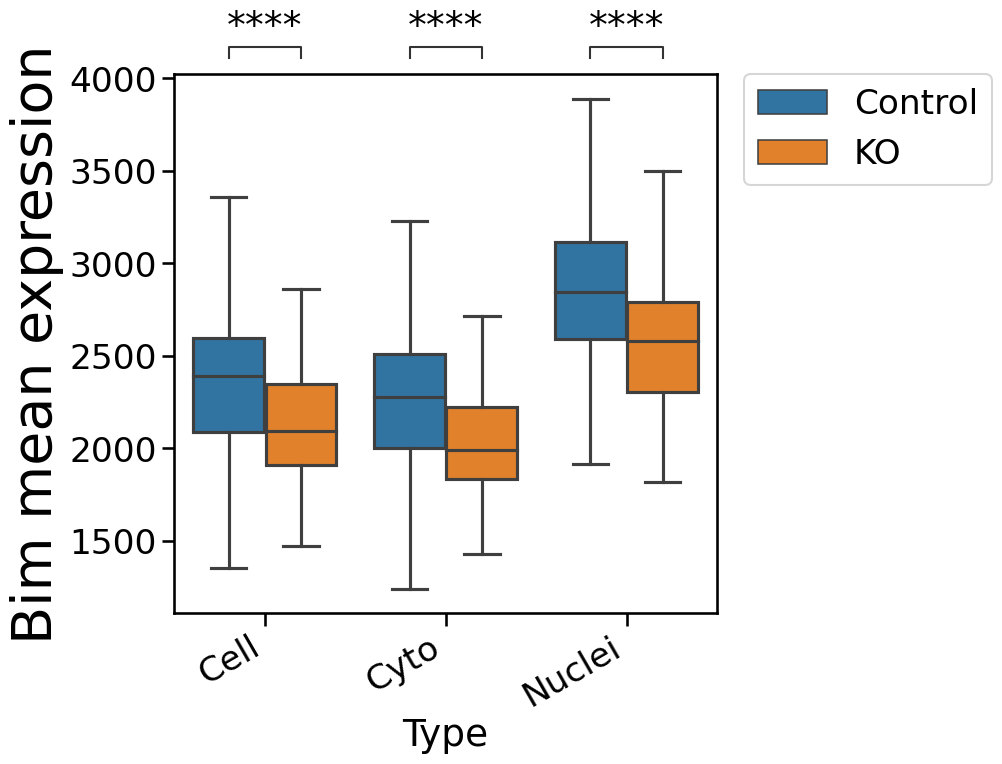

In [15]:
# Boxplot per cell
plotting = {
    "data": df,
    "x": "Type",
    "y": "Bim",
    "hue": "Conditon"
}

plot(plotting)

# Distribution plot

In [6]:
from skimage import util

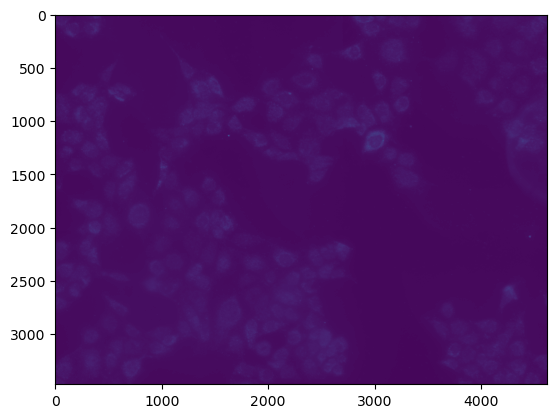

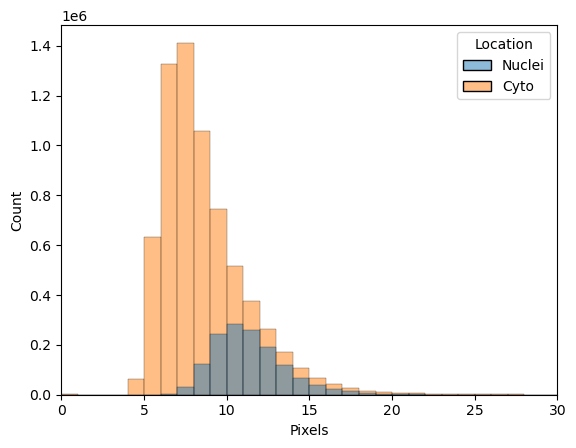

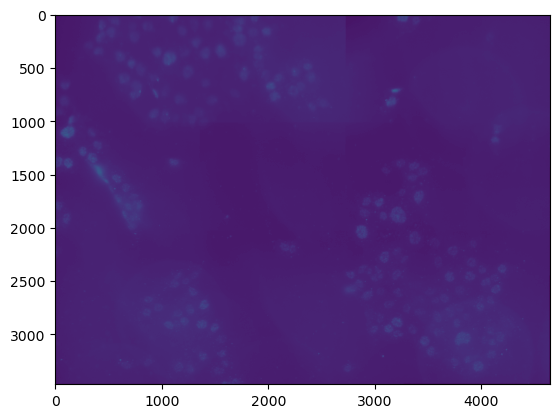

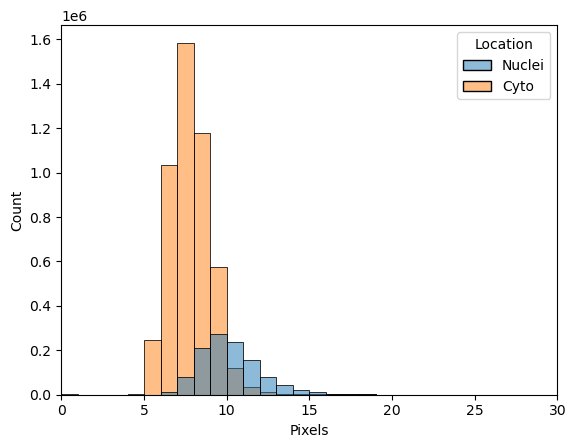

In [58]:
max_proj_dir = data_dir /  'specificity_IF_best' / 'imgs' / 'proj' 
df_imgs_path = data_dir /  'specificity_IF_best'  /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)

group = df_imgs.groupby('Condition')
imgs = []
df_props = []
dfs = [] 

for name, df_group in group:
    bim_path = max_proj_dir / f'{name}_Bim.tiff'
    img = skimage.io.imread(bim_path)
    img = util.img_as_ubyte(img)
    imgs.append(img)
    plt.imshow(img)
    plt.show()

    # Read masks
    mask_cell_path = masks_path[name]['cell']
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cell = skimage.io.imread(mask_cell_path)
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Get intensity distribution in nuclei and cytosol regions
    dfNuclei = pd.DataFrame(img[mask_nuclei>0])
    dfNuclei.columns = ['Pixels']
    dfNuclei['Location'] = 'Nuclei'

    dfCyto = pd.DataFrame(img[mask_cyto>0])
    dfCyto.columns = ['Pixels']
    dfCyto['Location'] = 'Cyto'

    df = pd.concat([dfNuclei, dfCyto])
    df.reset_index(inplace=True, drop=True)
    
    # Plot 
    fig, ax = plt.subplots()
    sns.histplot(df, x='Pixels', hue='Location',ax=ax, binwidth=1)
    ax.set_xlim(0, 30)
    plt.show()

    df['Type'] = name
    dfs.append(df)

    # for t,m in list(zip(['Cell', 'Cyto', 'Nuclei'], [mask_cell, mask_cyto, mask_nuclei])):
                
    #     break


In [60]:
df = pd.concat(dfs)
df.head()

,Pixels,Location,Type
0,12,Nuclei,Control
1,11,Nuclei,Control
2,9,Nuclei,Control
3,8,Nuclei,Control
4,9,Nuclei,Control


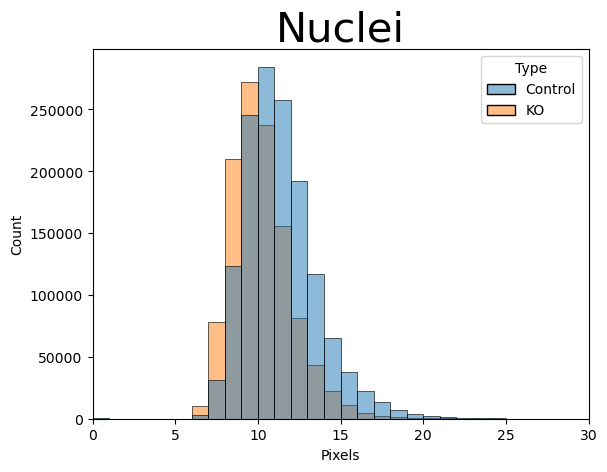

In [68]:
loc = 'Nuclei'
df_subset = df[df.Location == loc]
df_subset.reset_index(inplace=True, drop=True)
# Plot 
fig, ax = plt.subplots()
sns.histplot(df_subset, x='Pixels', hue='Type',ax=ax, binwidth=1)
ax.set_xlim(0, 30)
ax.set_title(loc, fontsize=30)
plt.show()

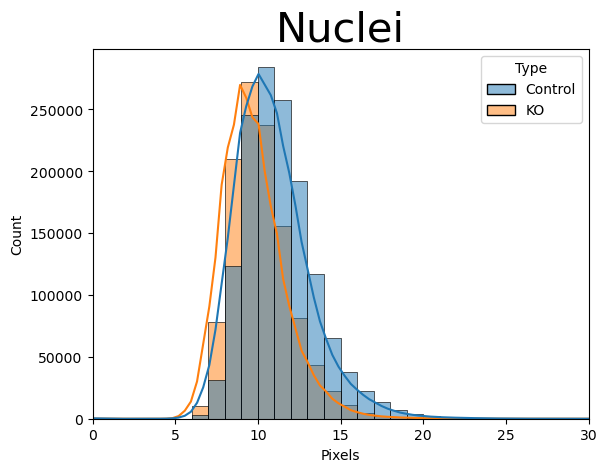

In [74]:
loc = 'Nuclei'
df_subset = df[df.Location == loc]
df_subset.reset_index(inplace=True, drop=True)
# Plot 
fig, ax = plt.subplots()
sns.histplot(df_subset, x='Pixels', hue='Type',ax=ax, binwidth=1, kde=True, kde_kws={'bw_adjust':4})
ax.set_xlim(0, 30)
ax.set_title(loc, fontsize=30)
plt.show()

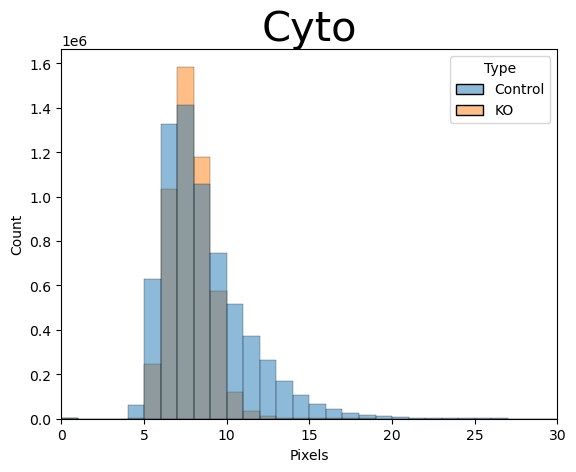

In [70]:
loc = 'Cyto'
df_subset = df[df.Location == loc]
df_subset.reset_index(inplace=True, drop=True)
# Plot 
fig, ax = plt.subplots()
sns.histplot(df_subset, x='Pixels', hue='Type',ax=ax, binwidth=1)
ax.set_xlim(0, 30)
ax.set_title(loc, fontsize=30)
plt.show()

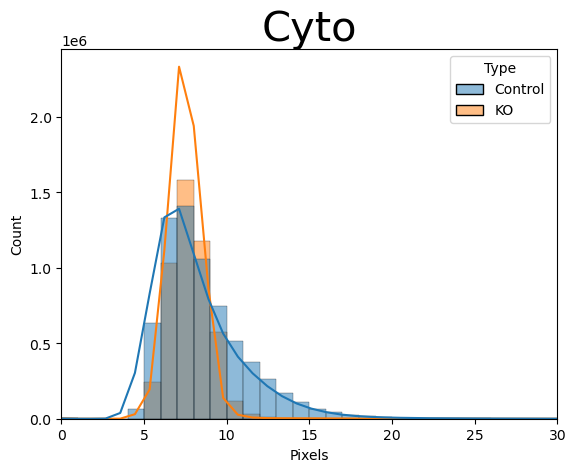

In [77]:
loc = 'Cyto'
df_subset = df[df.Location == loc]
df_subset.reset_index(inplace=True, drop=True)

# Plot 
fig, ax = plt.subplots()
sns.histplot(df_subset, x='Pixels', hue='Type',ax=ax, binwidth=1, kde=True, kde_kws={'bw_adjust':4})
ax.set_xlim(0, 30)
ax.set_title(loc, fontsize=30)
plt.show()

In [65]:
import napari

viewer = napari.view_image(img)
viewer.add_labels(mask_cyto)

<Labels layer 'mask_cyto' at 0x25f28e63490>